In [36]:
import os

import matplotlib.pyplot as plt
import pandas as pd

# Set up credentials
GEE_JSON = os.getenv("GEE_JSON")
PROJECT = os.getenv("PROJECT")
EXPORT_BUCKET = os.getenv("GEE_BUCKET")
EXPORT_PREFIX = "landscape_indicators_20230921"

DATA_FOLDER = "../data/raw"

In [37]:
country_stats = pd.read_csv(f"gs://{EXPORT_BUCKET}/{EXPORT_PREFIX}/country_stats_100m.csv")
country_kernel_stats = pd.read_csv(
    f"gs://{EXPORT_BUCKET}/{EXPORT_PREFIX}/sluc_kernel_country_stats_1000m.csv"
)
country_stats.set_index("ADM0_CODE", inplace=True)
country_kernel_stats.set_index("ADM0_CODE", inplace=True)
country_stats = country_stats.join(country_kernel_stats, rsuffix="2")
print(country_stats.columns)
country_stats.head()

Index(['system:index', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR', 'STATUS',
       'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'const', 'cropland',
       'deforest', 'deforest_carbon', 'dluc_cropland_deforest',
       'dluc_cropland_deforest_carbon', 'dluc_cropland_nattreeloss',
       'dluc_cropland_treeloss', 'dluc_nonnat_deforest',
       'dluc_nonnat_deforest_carbon', 'dluc_nonnat_nattreeloss',
       'dluc_nonnat_treeloss', 'nat_treeloss', 'nonnat', 'treeloss', '.geo',
       'system:index2', 'ADM0_NAME2', 'DISP_AREA2', 'EXP0_YEAR2', 'STATUS2',
       'STR0_YEAR2', 'Shape_Area2', 'Shape_Leng2', 'const2',
       'cropland_deforest_by_human_lu_0km_1000m',
       'cropland_deforest_by_human_lu_10km_1000m',
       'cropland_deforest_by_human_lu_25km_1000m',
       'cropland_deforest_by_human_lu_50km_1000m',
       'cropland_deforest_by_human_lu_5km_1000m',
       'cropland_deforest_carbon_by_human_lu_0km_1000m',
       'cropland_deforest_carbon_by_human_lu_10km_1000m',
       'cropland_defo

,system:index,ADM0_NAME,DISP_AREA,EXP0_YEAR,STATUS,STR0_YEAR,Shape_Area,Shape_Leng,const,cropland,...,nonnat_natural_crop_net_conversion_by_human_lu_10km_1000m,nonnat_natural_crop_net_conversion_by_human_lu_25km_1000m,nonnat_natural_crop_net_conversion_by_human_lu_50km_1000m,nonnat_natural_crop_net_conversion_by_human_lu_5km_1000m,nonnat_tree_loss_by_human_lu_0km_1000m,nonnat_tree_loss_by_human_lu_10km_1000m,nonnat_tree_loss_by_human_lu_25km_1000m,nonnat_tree_loss_by_human_lu_50km_1000m,nonnat_tree_loss_by_human_lu_5km_1000m,.geo2
ADM0_CODE,,,,,,,,,,,,,,,,,,,,,
1,00000000000000000029,Afghanistan,NO,3000,Member State,1000,62.554886,58.988002,6.418374e+05,28103.062837,...,252.812782,249.434493,258.646991,247.799409,1.178819,0.926596,0.962920,1.304262,0.945994,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,00000000000000000012,Aksai Chin,YES,3000,Sovereignty unsettled,1000,3.028950,10.774006,3.066542e+04,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000083,0.000060,0.000147,0.000103,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,00000000000000000067,Albania,NO,3000,Member State,1000,3.076365,13.494287,2.868165e+04,2001.537786,...,5.416760,3.335665,2.074649,7.490282,18.090614,23.885509,25.292438,24.989412,21.702992,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,000000000000000000a5,Algeria,NO,3000,Member State,1000,212.693097,81.248391,2.308743e+06,52583.702468,...,432.424044,430.955615,409.939208,435.046049,61.456965,110.267648,128.000490,119.097907,94.071457,"{""type"":""MultiPoint"",""coordinates"":[]}"
5,00010000000000000018,American Samoa,NO,3000,US Non-Self-Governing Territory,1000,0.016747,2.011719,1.999620e+02,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [38]:
# Load FAO data

country_df = pd.read_csv(f"{DATA_FOLDER}/country-codes.csv")
fao_forest_data = pd.read_csv(
    f"{DATA_FOLDER}/Emissions_Land_Use_Forests_E_All_Data_(Normalized).csv", encoding="latin-1"
)
fao_landuse_data = pd.read_csv(
    f"{DATA_FOLDER}/Inputs_LandUse_E_All_Data_(Normalized).csv", encoding="latin-1"
)

fao_forest_data = fao_forest_data[
    ((fao_forest_data["Year"] <= 2020) & (fao_forest_data["Year"] > 2000))
]
fao_forest_data["M49"] = fao_forest_data["Area Code (M49)"].apply(lambda x: x[1:]).astype(float)
fao_landuse_data = fao_landuse_data[
    ((fao_landuse_data["Year"] <= 2020) & (fao_landuse_data["Year"] > 2000))
]
fao_landuse_data["M49"] = fao_landuse_data["Area Code (M49)"].apply(lambda x: x[1:]).astype(float)

fao_area = (
    fao_forest_data[
        (
            (fao_forest_data["Source"] == "FAO TIER 1")
            & (fao_forest_data["Item"] == "Net Forest conversion")
            & (fao_forest_data["Element"] == "Area")
        )
    ]
    .groupby("M49")["Value"]
    .mean()
    * 10
)  # convert to km2
fao_area.name = "fao_forestloss"

fao_emissions = (
    fao_forest_data[
        (
            (fao_forest_data["Source"] == "FAO TIER 1")
            & (fao_forest_data["Item"] == "Net Forest conversion")
            & (fao_forest_data["Element"] == "Net emissions/removals (CO2) (Forest land)")
        )
    ]
    .groupby("M49")["Value"]
    .mean()
    * 10
)  # convert to km2
fao_emissions.name = "fao_emissions"

fao_cropland = (
    fao_landuse_data[((fao_landuse_data["Item"] == "Cropland"))].groupby("M49")["Value"].mean() * 10
)  # convert to km2
fao_cropland.name = "fao_cropland"

fao_agland = (
    fao_landuse_data[((fao_landuse_data["Item"] == "Agricultural land"))]
    .groupby("M49")["Value"]
    .mean()
    * 10
)  # convert to km2
fao_agland.name = "fao_agland"

all_fao = pd.concat([fao_area, fao_emissions, fao_cropland, fao_agland], axis=1)
all_fao.head()

,fao_forestloss,fao_emissions,fao_cropland,fao_agland
M49,,,,
1.0,112441.5935,3.408497e+07,3.835531e+06,2.400816e+07
2.0,38447.7740,1.036878e+07,6.600991e+05,5.649711e+06
4.0,0.0000,0.000000e+00,1.987535e+04,1.899405e+05
5.0,45454.7400,1.668472e+07,3.183579e+05,2.685978e+06
8.0,0.0000,0.000000e+00,1.952141e+03,6.019302e+03


In [39]:
c = country_df.drop(211)
c.GAUL = c.GAUL.astype(float)
c = c.filter(["GAUL", "CLDR display name", "Sub-region Name", "M49"])
c.rename(columns={"CLDR display name": "country_name", "Sub-region Name": "region"}, inplace=True)

all_stats = (
    country_stats.groupby("ADM0_CODE").sum().join(c.set_index("GAUL")).join(all_fao, on="M49")
)

# annualize
all_stats["treeloss"]
all_stats["nat_treeloss"]
all_stats["deforest"]
all_stats["dluc_cropland_deforest"]
all_stats["dluc_cropland_treeloss"]
all_stats["dluc_cropland_nattreeloss"]
all_stats["dluc_nonnat_deforest"]
all_stats["dluc_nonnat_treeloss"]
all_stats["dluc_nonnat_nattreeloss"]
# all_stats['deforest_carbon'] /= 20
# all_stats['dluc_cropland_deforest_carbon'] /= 20
# all_stats['dluc_nonnat_deforest_carbon'] /= 20

all_stats["sluc_treeloss_nonnat_ha"] = all_stats["treeloss"] / all_stats["nonnat"]
all_stats["sluc_treeloss_cropland_ha"] = all_stats["treeloss"] / all_stats["cropland"]
all_stats["sluc_treeloss_cropland"] = all_stats["cropland"] * all_stats["sluc_treeloss_nonnat_ha"]
all_stats["sluc_nat_treeloss_nonnat_ha"] = all_stats["nat_treeloss"] / all_stats["nonnat"]
all_stats["sluc_nat_treeloss_cropland_ha"] = all_stats["nat_treeloss"] / all_stats["cropland"]
all_stats["sluc_nat_treeloss_cropland"] = (
    all_stats["cropland"] * all_stats["sluc_nat_treeloss_nonnat_ha"]
)
all_stats["sluc_deforest_nonnat_ha"] = all_stats["deforest"] / all_stats["nonnat"]
all_stats["sluc_deforest_cropland_ha"] = all_stats["deforest"] / all_stats["cropland"]
all_stats["sluc_deforest_cropland"] = all_stats["cropland"] * all_stats["sluc_deforest_nonnat_ha"]
# all_stats['sluc_deforest_carbon_nonnat_ha'] = all_stats['deforest_carbon'] / all_stats['nonnat']
# all_stats['sluc_deforest_carbon_cropland_ha'] = all_stats['deforest_carbon'] \
#   / all_stats['cropland']
# all_stats['sluc_deforest_carbon_cropland'] = all_stats['cropland'] \
#   * all_stats['sluc_emissions_nonnat_ha']
all_stats["sluc_fao_agland_ha"] = all_stats["fao_forestloss"] / all_stats["fao_agland"]
all_stats["sluc_fao_cropland_ha"] = all_stats["fao_forestloss"] / all_stats["fao_cropland"]
all_stats["sluc_fao_cropland"] = all_stats["fao_cropland"] * all_stats["sluc_fao_agland_ha"]
all_stats["sluc_emissions_fao_agland_ha"] = all_stats["fao_emissions"] / all_stats["fao_agland"]
all_stats["sluc_emissions_fao_cropland_ha"] = all_stats["fao_emissions"] / all_stats["fao_cropland"]
all_stats["sluc_emissions_fao_cropland"] = (
    all_stats["fao_cropland"] * all_stats["sluc_emissions_fao_agland_ha"]
)

print(all_stats.columns)
all_stats.to_csv("../data/processed/sluc_vs_dluc_stats.csv")
all_stats.head()

Index(['system:index', 'ADM0_NAME', 'DISP_AREA', 'EXP0_YEAR', 'STATUS',
       'STR0_YEAR', 'Shape_Area', 'Shape_Leng', 'const', 'cropland',
       'deforest', 'deforest_carbon', 'dluc_cropland_deforest',
       'dluc_cropland_deforest_carbon', 'dluc_cropland_nattreeloss',
       'dluc_cropland_treeloss', 'dluc_nonnat_deforest',
       'dluc_nonnat_deforest_carbon', 'dluc_nonnat_nattreeloss',
       'dluc_nonnat_treeloss', 'nat_treeloss', 'nonnat', 'treeloss', '.geo',
       'system:index2', 'ADM0_NAME2', 'DISP_AREA2', 'EXP0_YEAR2', 'STATUS2',
       'STR0_YEAR2', 'Shape_Area2', 'Shape_Leng2', 'const2',
       'cropland_deforest_by_human_lu_0km_1000m',
       'cropland_deforest_by_human_lu_10km_1000m',
       'cropland_deforest_by_human_lu_25km_1000m',
       'cropland_deforest_by_human_lu_50km_1000m',
       'cropland_deforest_by_human_lu_5km_1000m',
       'cropland_deforest_carbon_by_human_lu_0km_1000m',
       'cropland_deforest_carbon_by_human_lu_10km_1000m',
       'cropland_defo

,system:index,ADM0_NAME,DISP_AREA,EXP0_YEAR,STATUS,STR0_YEAR,Shape_Area,Shape_Leng,const,cropland,...,sluc_nat_treeloss_cropland,sluc_deforest_nonnat_ha,sluc_deforest_cropland_ha,sluc_deforest_cropland,sluc_fao_agland_ha,sluc_fao_cropland_ha,sluc_fao_cropland,sluc_emissions_fao_agland_ha,sluc_emissions_fao_cropland_ha,sluc_emissions_fao_cropland
ADM0_CODE,,,,,,,,,,,,,,,,,,,,,
1.0,00000000000000000029,Afghanistan,NO,3000,Member State,1000,62.554886,58.988002,6.418374e+05,28103.062837,...,0.230096,0.000008,0.000023,0.211154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,00000000000000000012,Aksai Chin,YES,3000,Sovereignty unsettled,1000,3.028950,10.774006,3.066542e+04,0.000000,...,0.000000,0.000418,inf,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3.0,00000000000000000067,Albania,NO,3000,Member State,1000,3.076365,13.494287,2.868165e+04,2001.537786,...,6.049563,0.001011,0.003319,2.023105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4.0,000000000000000000a5,Algeria,NO,3000,Member State,1000,212.693097,81.248391,2.308743e+06,52583.702468,...,64.762061,0.000315,0.000583,16.579633,0.000160,0.001568,3.375622,0.011111,0.108616,233.791828
5.0,00010000000000000018,American Samoa,NO,3000,US Non-Self-Governing Territory,1000,0.016747,2.011719,1.999620e+02,0.000000,...,0.000000,0.000000,NaN,0.000000,0.003868,0.001038,1.117588,1.099468,0.295136,317.632372


In [40]:
c.region.unique()

array([nan, 'Southern Asia', 'Southern Europe', 'Northern Africa',
       'Polynesia', 'Sub-Saharan Africa',
       'Latin America and the Caribbean', 'Western Asia',
       'Australia and New Zealand', 'Western Europe', 'Eastern Europe',
       'Northern America', 'South-eastern Asia', 'Eastern Asia',
       'Northern Europe', 'Melanesia', 'Micronesia', 'Central Asia'],
      dtype=object)

<Axes: title={'center': 'Forest loss area (km2) / yr'}, xlabel='Country'>

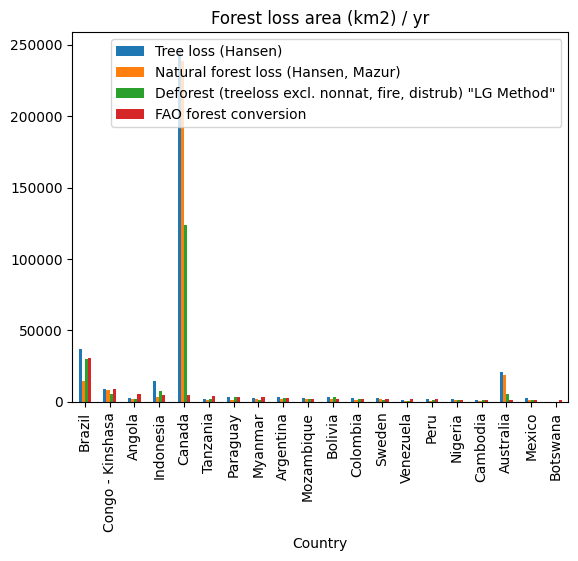

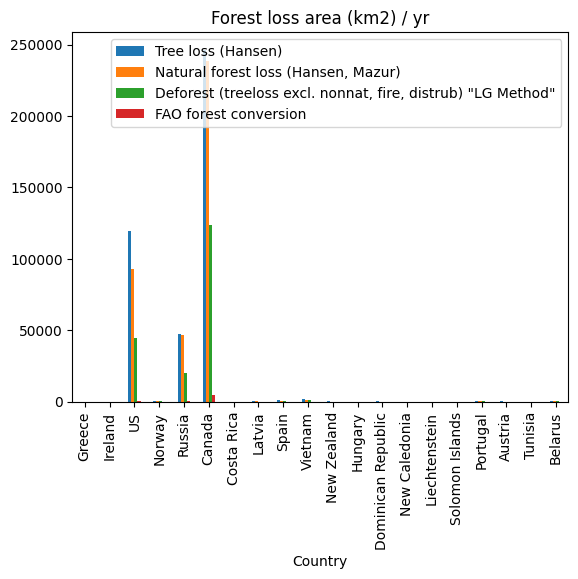

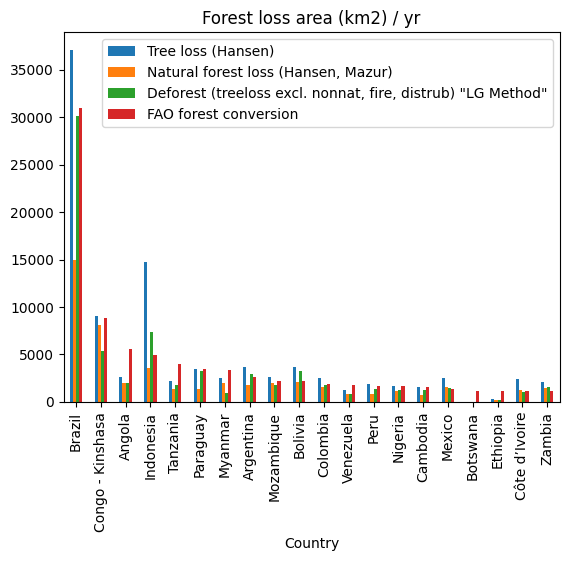

In [56]:
# Comparison of deforestation definitions
N = 20
SORT_COL = "fao_forestloss"
title = "Forest loss area (km2) / yr"
cols = {
    "country_name": "Country",
    "treeloss": "Tree loss (Hansen)",
    "nat_treeloss": "Natural forest loss (Hansen, Mazur)",
    "deforest": 'Deforest (treeloss excl. nonnat, fire, distrub) "LG Method"',
    "fao_forestloss": "FAO forest conversion",
}
all_stats.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.bar(x="Country", title=title)

all_stats["fao_ratio"] = all_stats["deforest"] / all_stats["fao_forestloss"]
all_stats[all_stats["fao_forestloss"] > 0].sort_values("fao_ratio", ascending=False).head(N).filter(
    cols.keys()
).rename(columns=cols).plot.bar(x="Country", title=title)


REGION_LIST = [
    "Southern Asia",  #'Southern Europe', 'Northern Africa',
    "Polynesia",
    "Sub-Saharan Africa",
    "Latin America and the Caribbean",  #'Western Asia',
    #'Australia and New Zealand', 'Western Europe', 'Eastern Europe',
    #'Northern America',
    "South-eastern Asia",
    "Eastern Asia",
    #'Northern Europe',
    "Melanesia",
    "Micronesia",  #'Central Asia'
]
all_stats_trop = all_stats[all_stats.region.isin(REGION_LIST)]
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.bar(x="Country", title=title)

/var/folders/dy/fpsjfhd97fbfjcd25y_m3_8m0000gn/T/ipykernel_25471/1630371954.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


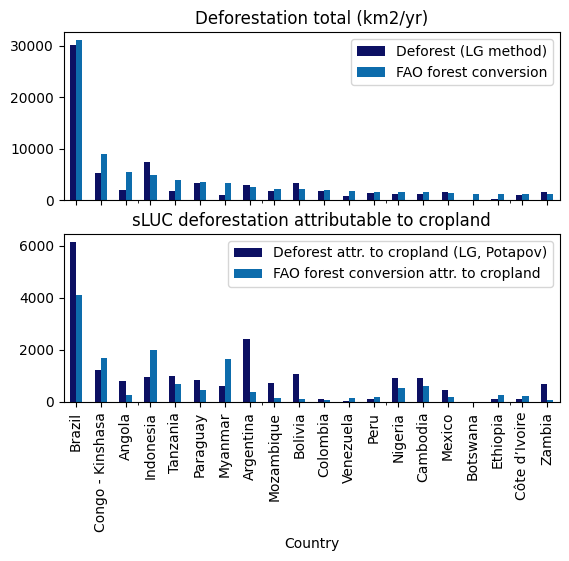

In [42]:
# Comparison of sLUC
c = ["#0c1063", "#0d6cac"]

fig, axs = plt.subplots(2, 1, sharex=True)
title = "Deforestation total (km2/yr)"
cols = {
    "country_name": "Country",
    "deforest": "Deforest (LG method)",
    "fao_forestloss": "FAO forest conversion",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.bar(x="Country", title=title, color=c, ax=axs[0])

title = "sLUC deforestation attributable to cropland"
cols = {
    "country_name": "Country",
    "sluc_deforest_cropland": "Deforest attr. to cropland (LG, Potapov)",
    "sluc_fao_cropland": "FAO forest conversion attr. to cropland",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.bar(x="Country", title=title, color=c, ax=axs[1])
fig.show()

/var/folders/dy/fpsjfhd97fbfjcd25y_m3_8m0000gn/T/ipykernel_25471/3719744870.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/dy/fpsjfhd97fbfjcd25y_m3_8m0000gn/T/ipykernel_25471/3719744870.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/dy/fpsjfhd97fbfjcd25y_m3_8m0000gn/T/ipykernel_25471/3719744870.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


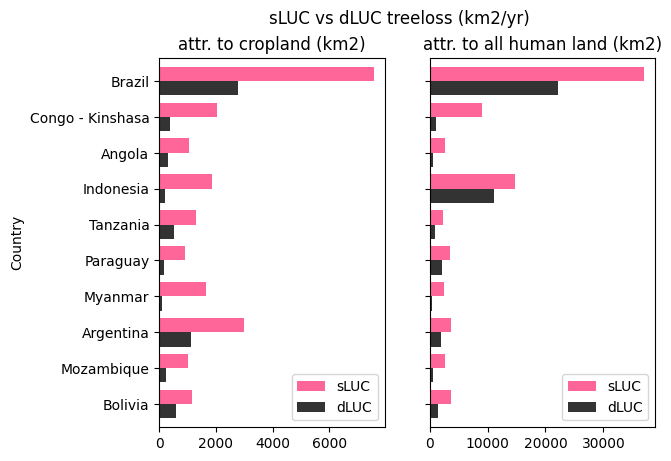

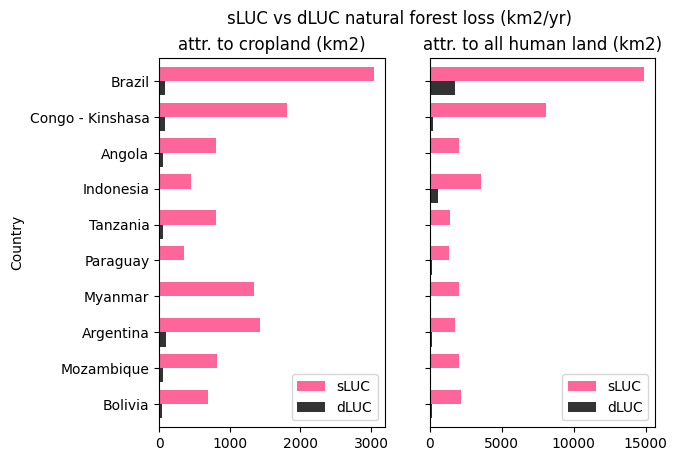

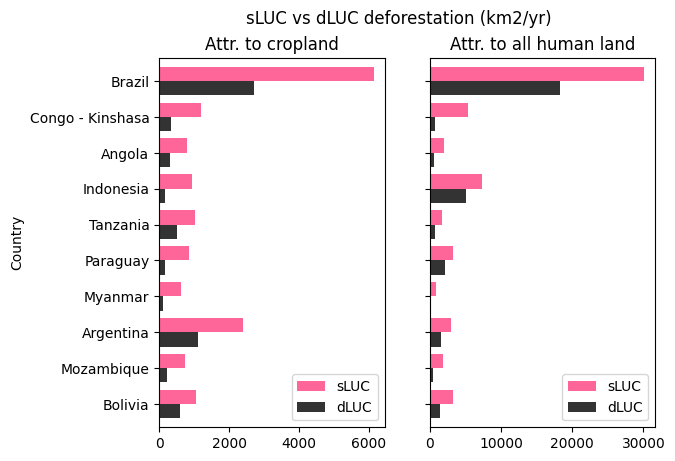

In [43]:
# dLUC
c = ["#fe6598", "#333333"]
N = 10

fig, axs = plt.subplots(1, 2, sharey=True)
fig.suptitle("sLUC vs dLUC treeloss (km2/yr)")
title = "attr. to all human land (km2)"
cols = {
    "country_name": "Country",
    "treeloss": "sLUC",
    "dluc_nonnat_treeloss": "dLUC",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.barh(x="Country", title=title, color=c, ax=axs[1], width=0.8).invert_yaxis()
title = "attr. to cropland (km2)"
cols = {
    "country_name": "Country",
    "sluc_treeloss_cropland": "sLUC",
    "dluc_cropland_treeloss": "dLUC",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.barh(x="Country", title=title, color=c, ax=axs[0], width=0.8).invert_yaxis()
fig.show()

fig, axs = plt.subplots(1, 2, sharey=True)
fig.suptitle("sLUC vs dLUC natural forest loss (km2/yr)")
title = "attr. to all human land (km2)"
cols = {
    "country_name": "Country",
    "nat_treeloss": "sLUC",
    "dluc_nonnat_nattreeloss": "dLUC",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.barh(x="Country", title=title, color=c, ax=axs[1], width=0.8).invert_yaxis()
title = "attr. to cropland (km2)"
cols = {
    "country_name": "Country",
    "sluc_nat_treeloss_cropland": "sLUC",
    "dluc_cropland_nattreeloss": "dLUC",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.barh(x="Country", title=title, color=c, ax=axs[0], width=0.8).invert_yaxis()
fig.show()

fig, axs = plt.subplots(1, 2, sharey=True)
fig.suptitle("sLUC vs dLUC deforestation (km2/yr)")
title = "Attr. to all human land"
cols = {
    "country_name": "Country",
    "deforest": "sLUC",
    "dluc_nonnat_deforest": "dLUC",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.barh(x="Country", title=title, color=c, ax=axs[1], width=0.8).invert_yaxis()
title = "Attr. to cropland"
cols = {
    "country_name": "Country",
    "sluc_deforest_cropland": "sLUC",
    "dluc_cropland_deforest": "dLUC",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.barh(x="Country", title=title, color=c, ax=axs[0], width=0.8).invert_yaxis()
fig.show()

Cropland
Tropical countries
sLUC countrywide 1.29
sLUC 50km kernel 1.378
sLUC 25km kernel 1.306
sLUC 10km kernel 1.221
sLUC 5km kernel 1.165
sLUC 0.5km kernel 1.021
dLUC 0.488
All countries
sLUC countrywide 7.376
sLUC 50km kernel 2.948
sLUC 25km kernel 2.597
sLUC 10km kernel 2.255
sLUC 5km kernel 2.057
sLUC 0.5km kernel 1.557
dLUC 0.535
All HLU
Tropical countries
sLUC countrywide 0.863
sLUC 50km kernel 0.752
sLUC 25km kernel 0.726
sLUC 10km kernel 0.691
sLUC 5km kernel 0.665
sLUC 0.5km kernel 0.621
dLUC 0.42
All countries
sLUC countrywide 2.585
sLUC 50km kernel 1.516
sLUC 25km kernel 1.42
sLUC 10km kernel 1.297
sLUC 5km kernel 1.205
sLUC 0.5km kernel 1.029
dLUC 0.502


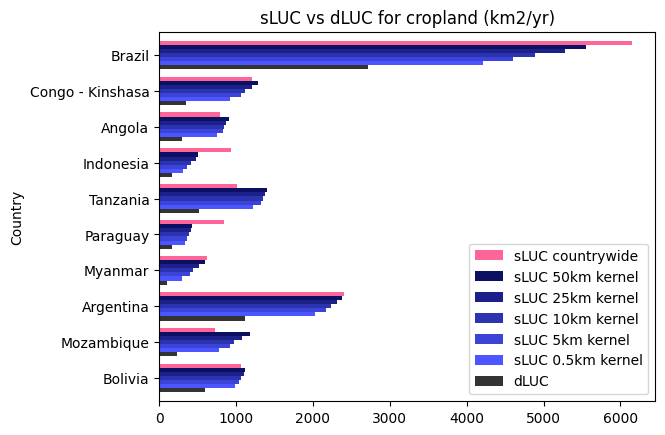

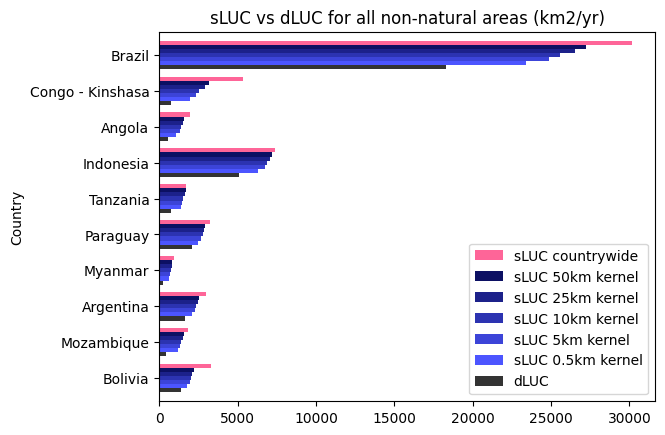

In [45]:
# spatial sLUC

c = ["#fe6598", "#0C1063", "#1C218A", "#2C33B1", "#3C44D8", "#4C55FF", "#333333"]

title = "sLUC vs dLUC for cropland (km2/yr)"
cols = {
    "country_name": "Country",
    "sluc_deforest_cropland": "sLUC countrywide",
    "cropland_deforest_by_human_lu_50km_1000m": "sLUC 50km kernel",
    "cropland_deforest_by_human_lu_25km_1000m": "sLUC 25km kernel",
    "cropland_deforest_by_human_lu_10km_1000m": "sLUC 10km kernel",
    "cropland_deforest_by_human_lu_5km_1000m": "sLUC 5km kernel",
    "cropland_deforest_by_human_lu_0km_1000m": "sLUC 0.5km kernel",
    "dluc_cropland_deforest": "dLUC",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.barh(x="Country", color=c, title=title, width=0.8).invert_yaxis()


title = "sLUC vs dLUC for all non-natural areas (km2/yr)"
cols = {
    "country_name": "Country",
    "deforest": "sLUC countrywide",
    "nonnat_deforest_by_human_lu_50km_1000m": "sLUC 50km kernel",
    "nonnat_deforest_by_human_lu_25km_1000m": "sLUC 25km kernel",
    "nonnat_deforest_by_human_lu_10km_1000m": "sLUC 10km kernel",
    "nonnat_deforest_by_human_lu_5km_1000m": "sLUC 5km kernel",
    "nonnat_deforest_by_human_lu_0km_1000m": "sLUC 0.5km kernel",
    "dluc_nonnat_deforest": "dLUC",
}
all_stats_trop.sort_values(SORT_COL, ascending=False).head(N).filter(cols.keys()).rename(
    columns=cols
).plot.barh(x="Country", color=c, title=title, width=0.8).invert_yaxis()

In [55]:
print("Cropland")
print("Tropical countries")
denom = "sluc_fao_cropland"
# denom = "sluc_deforest_cropland"

all_stats_f = all_stats[all_stats[denom] > 0]
all_stats_trop_f = all_stats_trop[all_stats_trop[denom] > 0]

cols = {
    "country_name": "Country",
    "sluc_deforest_cropland": "sLUC countrywide",
    "cropland_deforest_by_human_lu_50km_1000m": "sLUC 50km kernel",
    "cropland_deforest_by_human_lu_25km_1000m": "sLUC 25km kernel",
    "cropland_deforest_by_human_lu_10km_1000m": "sLUC 10km kernel",
    "cropland_deforest_by_human_lu_5km_1000m": "sLUC 5km kernel",
    "cropland_deforest_by_human_lu_0km_1000m": "sLUC 0.5km kernel",
    "dluc_cropland_deforest": "dLUC",
}

for col, lyr in cols.items():
    if col != "country_name":
        print(lyr, round(all_stats_trop_f[col].sum() / all_stats_trop_f[denom].sum(), 3))
print("All countries")
for col, lyr in cols.items():
    if col != "country_name":
        print(lyr, round(all_stats_f[col].sum() / all_stats_f[denom].sum(), 3))

print("All HLU")
print("Tropical countries")
denom = "fao_forestloss"
# denom = "deforest"

all_stats_f = all_stats[all_stats[denom] > 0]
all_stats_trop_f = all_stats_trop[all_stats_trop[denom] > 0]


cols = {
    "country_name": "Country",
    "deforest": "sLUC countrywide",
    "nonnat_deforest_by_human_lu_50km_1000m": "sLUC 50km kernel",
    "nonnat_deforest_by_human_lu_25km_1000m": "sLUC 25km kernel",
    "nonnat_deforest_by_human_lu_10km_1000m": "sLUC 10km kernel",
    "nonnat_deforest_by_human_lu_5km_1000m": "sLUC 5km kernel",
    "nonnat_deforest_by_human_lu_0km_1000m": "sLUC 0.5km kernel",
    "dluc_nonnat_deforest": "dLUC",
}

for col, lyr in cols.items():
    if col != "country_name":
        print(lyr, round(all_stats_trop_f[col].sum() / all_stats_trop_f[denom].sum(), 3))
print("All countries")
for col, lyr in cols.items():
    if col != "country_name":
        print(lyr, round(all_stats_f[col].sum() / all_stats_f[denom].sum(), 3))

Cropland
Tropical countries
sLUC countrywide 1.28
sLUC 50km kernel 1.363
sLUC 25km kernel 1.292
sLUC 10km kernel 1.209
sLUC 5km kernel 1.155
sLUC 0.5km kernel 1.014
dLUC 0.486
All countries
sLUC countrywide 7.306
sLUC 50km kernel 2.849
sLUC 25km kernel 2.501
sLUC 10km kernel 2.164
sLUC 5km kernel 1.971
sLUC 0.5km kernel 1.5
dLUC 0.524
All HLU
Tropical countries
sLUC countrywide 0.856
sLUC 50km kernel 0.745
sLUC 25km kernel 0.718
sLUC 10km kernel 0.684
sLUC 5km kernel 0.658
sLUC 0.5km kernel 0.614
dLUC 0.416
All countries
sLUC countrywide 2.553
sLUC 50km kernel 1.48
sLUC 25km kernel 1.385
sLUC 10km kernel 1.262
sLUC 5km kernel 1.17
sLUC 0.5km kernel 0.988
dLUC 0.49
